In [2]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
datapath = "data/pvpcdata.csv"
day = 24

In [5]:
df = pd.read_csv(datapath, sep = ";")

In [6]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [7]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [8]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [9]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [10]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

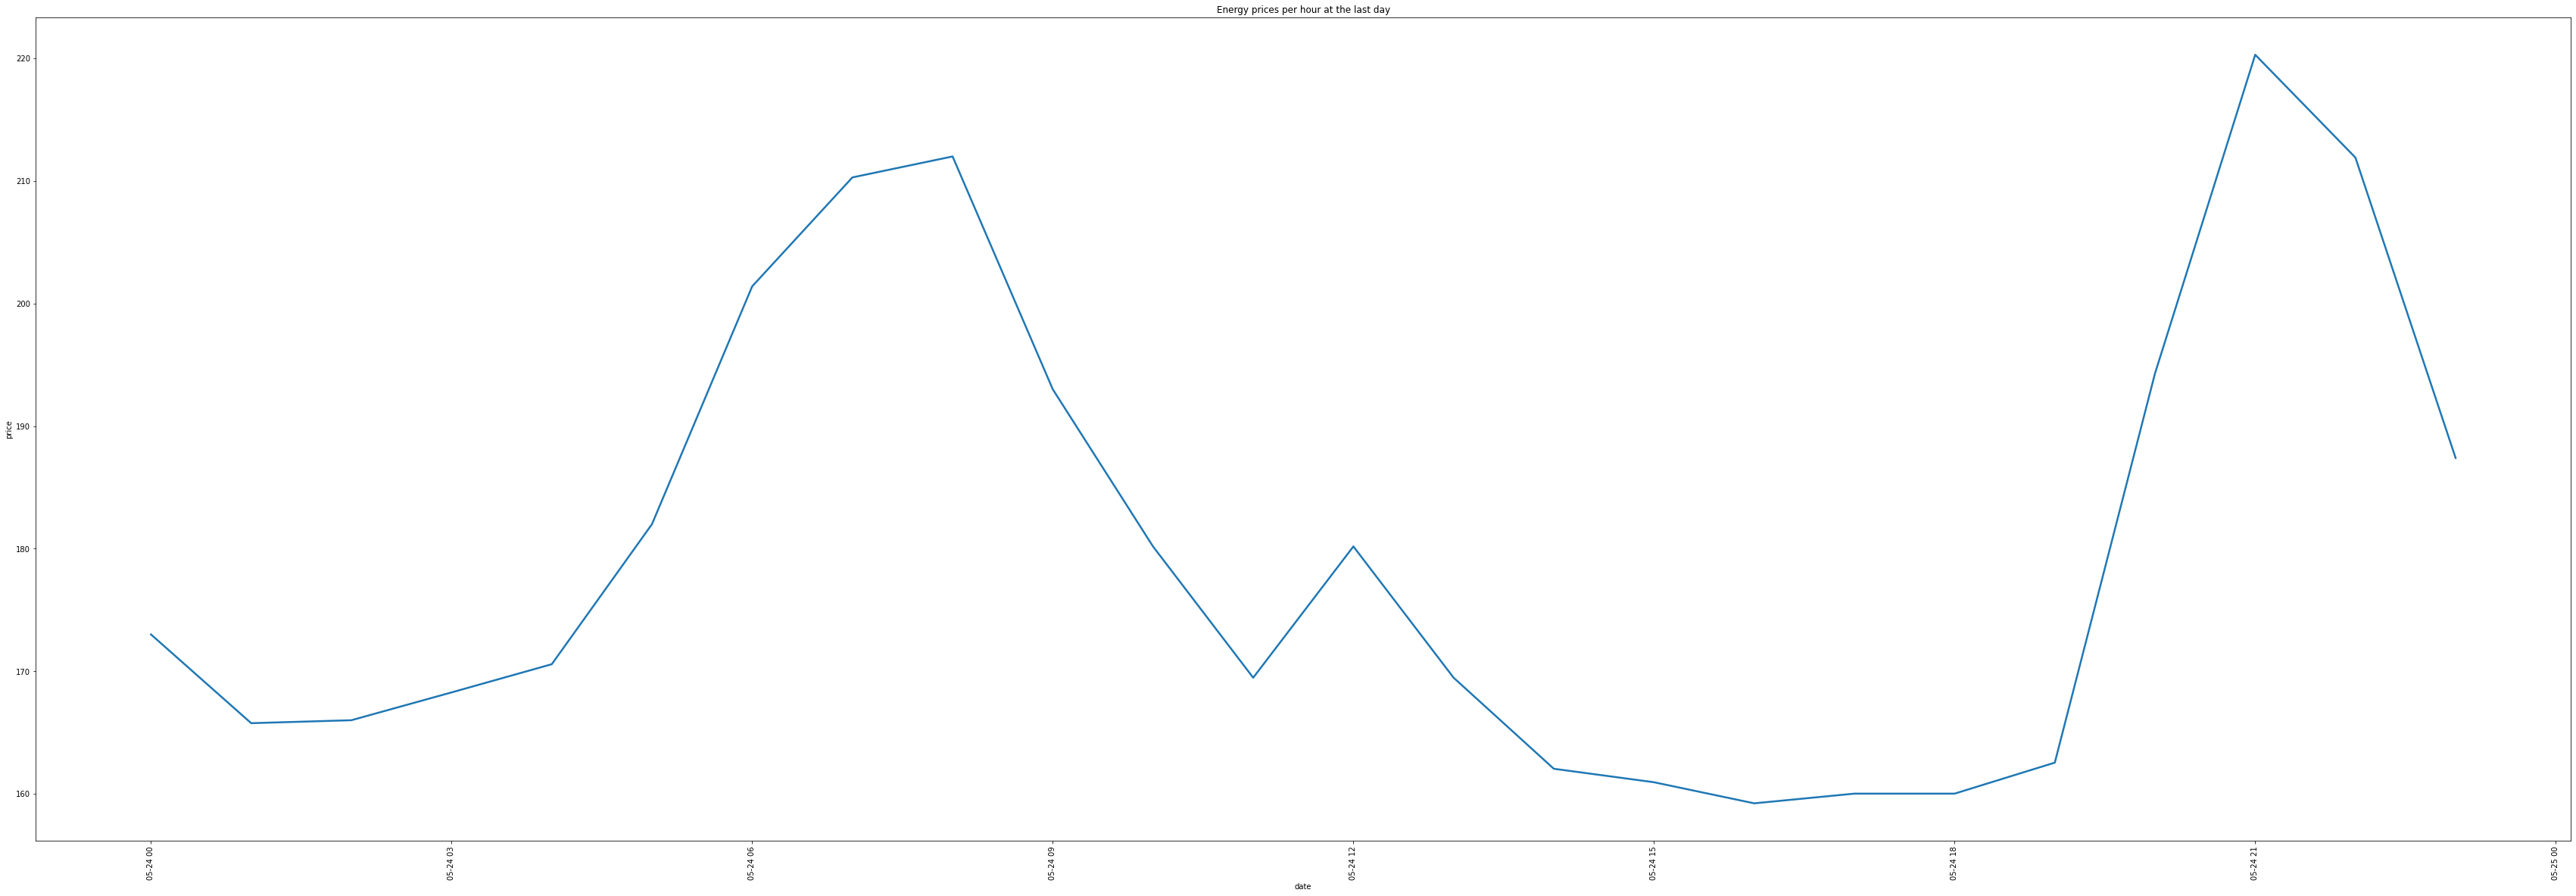

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90)
sns.lineplot(x = 'date', y = 'price', data = df.tail(day), linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [22]:
sec_day = 24*60*60
sec_year = 365.2425 * day
sec_week = sec_day * 7

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana de 5
w_size = 5
#Número de entradas
n_inputs = len(df.columns)

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [r for r in df_as_np[i:i + w_size]]
        x.append(row)
        
        #Solo queremos el precio
        label = df_as_np[i + w_size][0]
        y.append(label)
    
    return np.array(x), np.array(y)

In [17]:
x, y = df_to_x_y_multiple(df, 5)
x.shape, y.shape

((47293, 5, 5), (47293,))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((33105, 5, 5), (33105,), (9505, 5, 5), (9505,), (4683, 5, 5), (4683,))

In [19]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [20]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [21]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [22]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [23]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()

2022-06-07 11:30:02.178743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 11:30:03.183757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17269 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-07 11:30:03.185008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26273 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [ ]:
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200


2022-06-07 11:30:05.299152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


1035/1035 [==============================] - 10s 8ms/step - loss: 303.3355 - mae: 10.0751 - mse: 303.3355 - val_loss: 30157.4785 - val_mae: 158.5627 - val_mse: 30157.4785
Epoch 2/200
1035/1035 [==============================] - 8s 7ms/step - loss: 12.0767 - mae: 2.2258 - mse: 12.0767 - val_loss: 26525.5723 - val_mae: 147.0581 - val_mse: 26525.5723
Epoch 3/200
1035/1035 [==============================] - 8s 7ms/step - loss: 7.7045 - mae: 1.8587 - mse: 7.7045 - val_loss: 24400.9746 - val_mae: 139.8966 - val_mse: 24400.9746
Epoch 4/200
1035/1035 [==============================] - 8s 8ms/step - loss: 6.5883 - mae: 1.7619 - mse: 6.5883 - val_loss: 24868.6328 - val_mae: 141.6722 - val_mse: 24868.6328
Epoch 5/200
1035/1035 [==============================] - 8s 8ms/step - loss: 6.1914 - mae: 1.7108 - mse: 6.1914 - val_loss: 24068.3809 - val_mae: 138.7920 - val_mse: 24068.3809
Epoch 6/200
1035/1035 [==============================] - 8s 7ms/step - loss: 6.0395 - mae: 1.7132 - mse: 6.0395 - val_l

In [27]:
history_cnn = model_cnn.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

1035/1035 [==============================] - 6s 5ms/step - loss: 6.9805 - mae: 1.8016 - mse: 6.9805 - val_loss: 350.6220 - val_mae: 13.2469 - val_mse: 350.6220
Epoch 4/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.0531 - mae: 1.8235 - mse: 7.0531 - val_loss: 385.3546 - val_mae: 14.3293 - val_mse: 385.3546
Epoch 5/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.1206 - mae: 1.8428 - mse: 7.1206 - val_loss: 387.2720 - val_mae: 14.3890 - val_mse: 387.2720
Epoch 6/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.1236 - mae: 1.8485 - mse: 7.1236 - val_loss: 393.9620 - val_mae: 14.5967 - val_mse: 393.9620
Epoch 7/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.0761 - mae: 1.8427 - mse: 7.0761 - val_loss: 439.0552 - val_mae: 15.8766 - val_mse: 439.0552
Epoch 8/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.0059 - mae: 1.8315 - mse: 7.0059 - val_loss: 485.5917 - val_mae: 17.1153 

In [28]:
history_gru = model_gru.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 9s 8ms/step - loss: 391.5355 - mae: 11.8285 - mse: 391.5355 - val_loss: 33684.8945 - val_mae: 168.3574 - val_mse: 33684.8945
Epoch 2/200
1035/1035 [==============================] - 7s 7ms/step - loss: 10.9493 - mae: 2.0898 - mse: 10.9493 - val_loss: 31070.8184 - val_mae: 160.5578 - val_mse: 31070.8184
Epoch 3/200
1035/1035 [==============================] - 7s 7ms/step - loss: 7.4217 - mae: 1.7867 - mse: 7.4217 - val_loss: 28618.0918 - val_mae: 153.4176 - val_mse: 28618.0918
Epoch 4/200
1035/1035 [==============================] - 7s 7ms/step - loss: 6.0324 - mae: 1.6583 - mse: 6.0324 - val_loss: 29098.6367 - val_mae: 155.2585 - val_mse: 29098.6367
Epoch 5/200
1035/1035 [==============================] - 7s 7ms/step - loss: 5.5789 - mae: 1.6366 - mse: 5.5789 - val_loss: 27388.1582 - val_mae: 149.5152 - val_mse: 27388.1582
Epoch 6/200
1035/1035 [==============================] - 7s 7ms/step - loss: 5.8114 - mae: 1.6671 - mse: 5.8

In [29]:
history_lstm_ret_seq = model_lstm_ret_seq.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 13s 11ms/step - loss: 458.2003 - mae: 13.9686 - mse: 458.2003 - val_loss: 31385.6211 - val_mae: 163.3494 - val_mse: 31385.6211
Epoch 2/200
1035/1035 [==============================] - 11s 10ms/step - loss: 20.2718 - mae: 2.7381 - mse: 20.2718 - val_loss: 27194.4902 - val_mae: 150.2177 - val_mse: 27194.4902
Epoch 3/200
1035/1035 [==============================] - 11s 10ms/step - loss: 9.6305 - mae: 2.0280 - mse: 9.6305 - val_loss: 25474.7578 - val_mae: 144.5115 - val_mse: 25474.7578
Epoch 4/200
1035/1035 [==============================] - 11s 10ms/step - loss: 7.4453 - mae: 1.8318 - mse: 7.4453 - val_loss: 24268.8359 - val_mae: 140.3931 - val_mse: 24268.8359
Epoch 5/200
1035/1035 [==============================] - 11s 10ms/step - loss: 6.7301 - mae: 1.7832 - mse: 6.7301 - val_loss: 22770.5000 - val_mae: 135.3086 - val_mse: 22770.5000
Epoch 6/200
1035/1035 [==============================] - 11s 10ms/step - loss: 6.2844 - mae: 1.741

In [30]:
history_cnn_relu = model_cnn_relu.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 6s 5ms/step - loss: 42.1479 - mae: 3.4944 - mse: 42.1479 - val_loss: 446.9323 - val_mae: 15.2473 - val_mse: 446.9323
Epoch 2/200
1035/1035 [==============================] - 6s 5ms/step - loss: 6.2828 - mae: 1.7191 - mse: 6.2828 - val_loss: 447.7978 - val_mae: 15.6040 - val_mse: 447.7978
Epoch 3/200
1035/1035 [==============================] - 6s 5ms/step - loss: 5.8736 - mae: 1.6703 - mse: 5.8736 - val_loss: 449.4434 - val_mae: 15.6268 - val_mse: 449.4434
Epoch 4/200
1035/1035 [==============================] - 6s 5ms/step - loss: 5.7502 - mae: 1.6603 - mse: 5.7502 - val_loss: 435.2278 - val_mae: 15.1074 - val_mse: 435.2278
Epoch 5/200
1035/1035 [==============================] - 6s 5ms/step - loss: 5.6807 - mae: 1.6569 - mse: 5.6807 - val_loss: 454.2763 - val_mae: 15.6010 - val_mse: 454.2763
Epoch 6/200
1035/1035 [==============================] - 6s 5ms/step - loss: 5.6394 - mae: 1.6552 - mse: 5.6394 - val_loss: 454.7414 - val

In [31]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

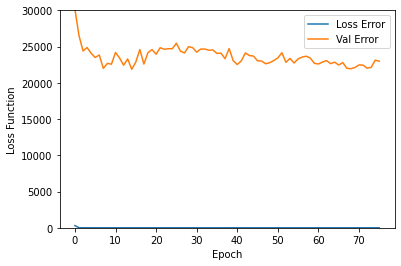

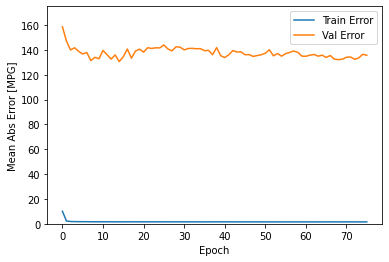

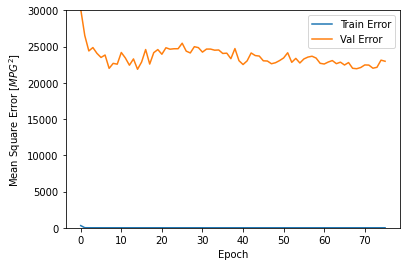

In [32]:
plot_history(history_lstm, 0, 30000, 175, 30000)

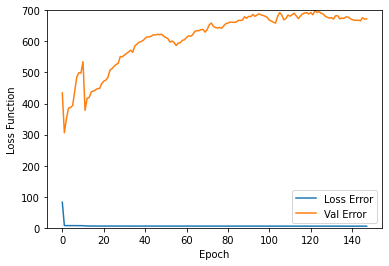

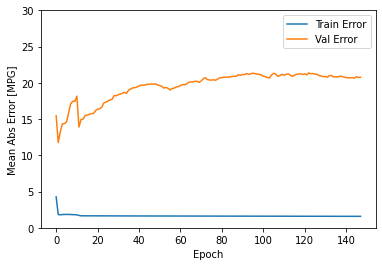

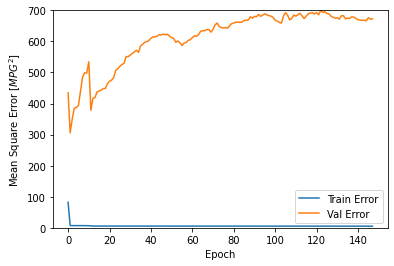

In [33]:
plot_history(history_cnn, 0, 700, 30, 700)

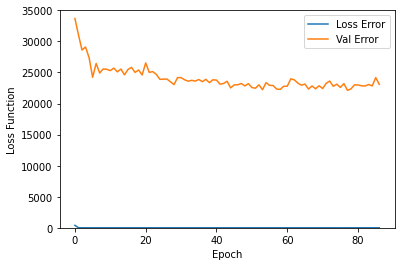

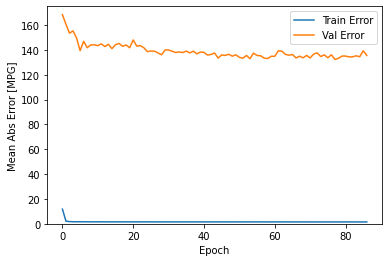

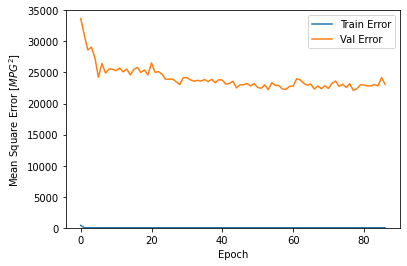

In [34]:
plot_history(history_gru, 0, 35000, 175, 35000)

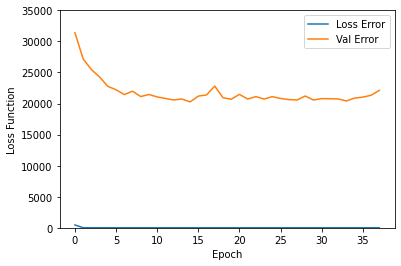

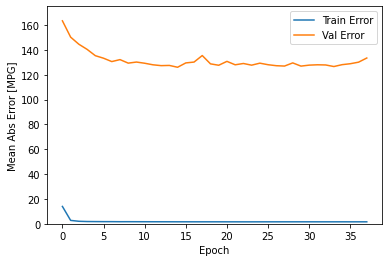

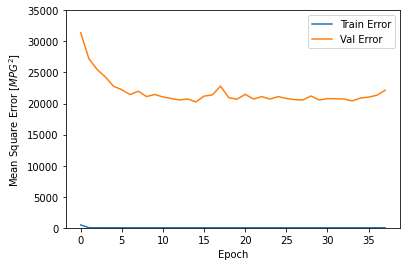

In [35]:
plot_history(history_lstm_ret_seq, 0, 35000, 175, 35000)

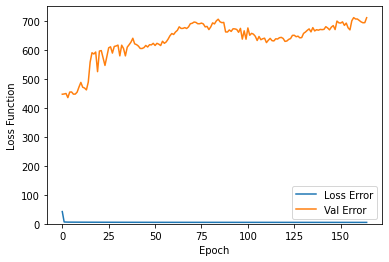

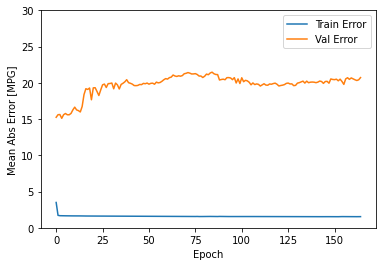

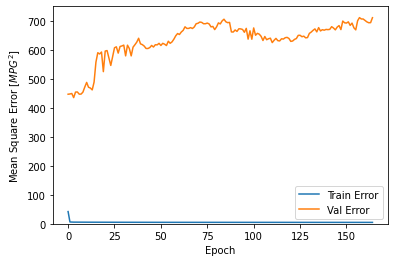

In [36]:
plot_history(history_cnn_relu, 0, 750, 30, 750)

In [37]:
y_pred_lstm = model_lstm.predict(x_test)
y_pred_cnn = model_cnn.predict(x_test)
y_pred_gru = model_gru.predict(x_test)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test)
y_pred_cnn_relu = model_cnn_relu.predict(x_test)

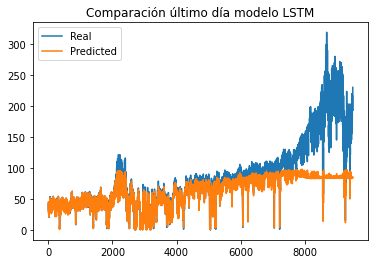

In [38]:
plt.plot(y_test, label='Real')
plt.plot(y_pred_lstm, label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

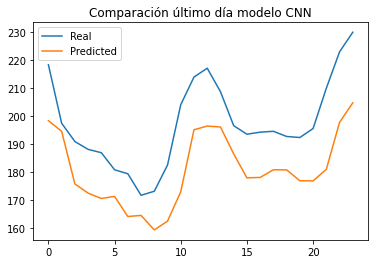

In [39]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

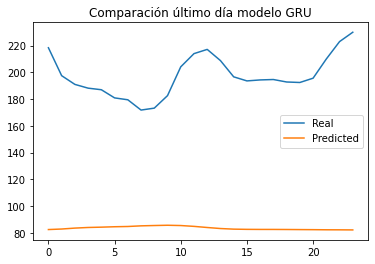

In [40]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

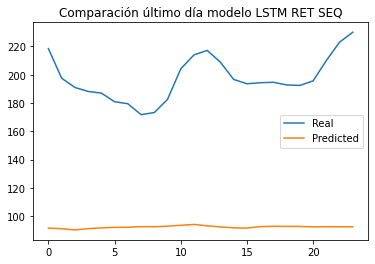

In [41]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_ret_seq[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

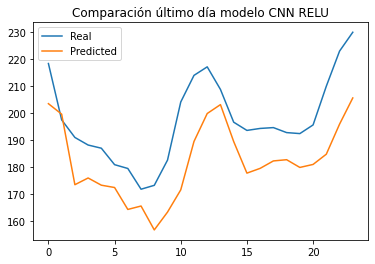

In [42]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn_relu[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [43]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)

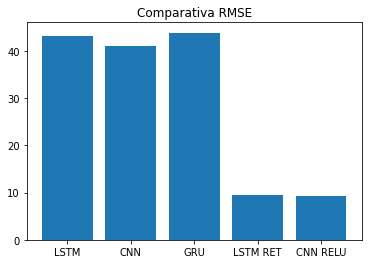

In [44]:
x_axis = ["LSTM", "CNN", "GRU", "LSTM RET", "CNN RELU"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_gru, rmse_cnn, rmse_cnn_relu]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

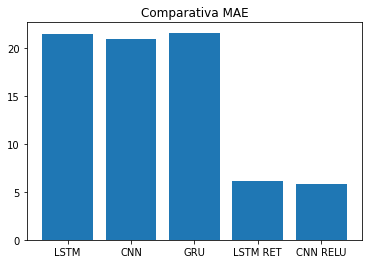

In [45]:
x_axis = ["LSTM", "CNN", "GRU", "LSTM RET", "CNN RELU"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_gru, mae_cnn, mae_cnn_relu]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [23]:
df['date'] = timestamp

In [24]:
print(df.head)

<bound method NDFrame.head of         price       day_sin       day_cos  year_sin  year_cos          date  \
0       58.82 -2.588190e-01  9.659258e-01 -0.173998 -0.984746  1.483225e+09   
1       58.23  2.504006e-13  1.000000e+00 -0.376753  0.926314  1.483229e+09   
2       51.95  2.588190e-01  9.659258e-01  0.811938 -0.583744  1.483232e+09   
3       47.27  5.000000e-01  8.660254e-01 -0.998069  0.062116  1.483236e+09   
4       46.90  7.071068e-01  7.071068e-01  0.878052  0.478566  1.483240e+09   
...       ...           ...           ...       ...       ...           ...   
47298  162.54 -9.659258e-01 -2.588190e-01  0.950645 -0.310281  1.653412e+09   
47299  194.30 -1.000000e+00 -1.283175e-11 -0.969970 -0.243224  1.653415e+09   
47300  220.30 -9.659258e-01  2.588190e-01  0.691766  0.722121  1.653419e+09   
47301  211.91 -8.660254e-01  5.000000e-01 -0.201370 -0.979515  1.653422e+09   
47302  187.40 -7.071068e-01  7.071068e-01 -0.350795  0.936452  1.653426e+09   

       week_sin  week

In [25]:
df.to_csv (r'csvdatanonorm.csv', index = False, header=True)